In [33]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import PHELPH


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
system = PHELPH.PHELPH(kmax=2.0, n_kmax=80)

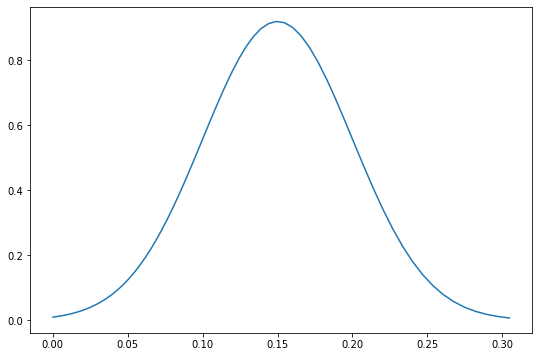

In [175]:
system.T_cryo = 300

inits = system.get_init_cond_gauss(max_pos = 0.15, width = 0.05, density=0.12, I_0=1e-6)

plt.plot(system.E_el_vec,inits[:system.n_kmax])
plt.show()

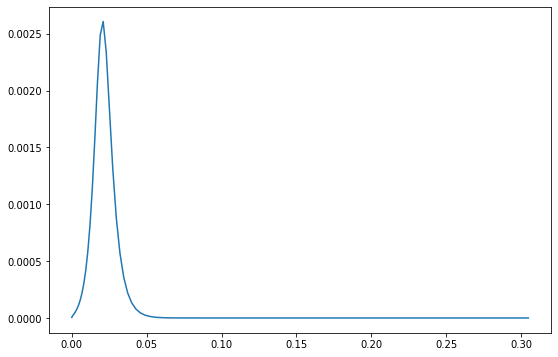

In [196]:
# #with oscillation
# system.g_photon = 0.1
# system.tau_photon = 20
# system.E_photon = 0.02
# system.linewidth = 0.002

#smooth
system.g_photon = 0.01
system.tau_photon = 200
system.E_photon = 0.02
system.linewidth = 0.005

system.setup_laser()

plt.plot(system.E_el_vec,system.I_gain_helper_vec)
plt.show()

In [197]:
trajectory = system.get_full_trajectory(inits, tmax=10000, n_tmax=1001)

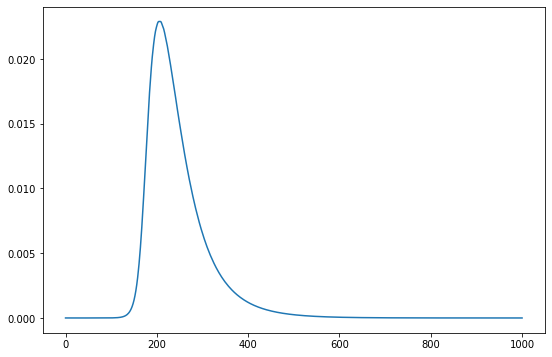

In [198]:
plt.plot(trajectory[:,-1])
plt.show()

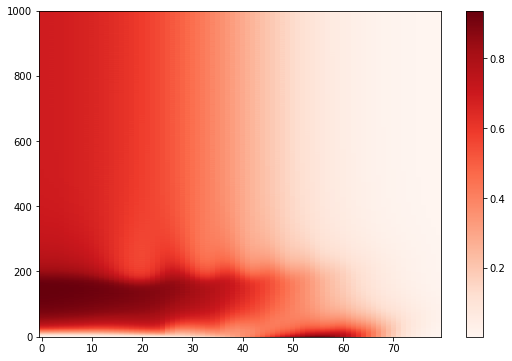

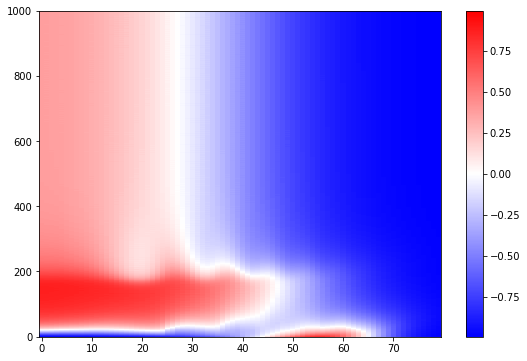

In [199]:
import matplotlib.colors as colors

plt.imshow(trajectory[:,:system.n_kmax], aspect='auto', interpolation='none', origin='lower',cmap='Reds')
plt.colorbar()
plt.show()


inversion = 2*trajectory[:,:system.n_kmax] - 1.

plt.imshow(inversion, aspect='auto', interpolation='none', origin='lower',
           cmap='bwr',
           norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

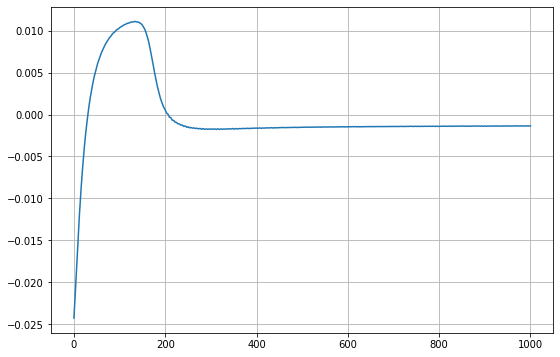

In [200]:
gain = [system.get_net_photon_gain(el_state) for el_state in trajectory[:,:system.n_kmax] ]


plt.grid()
plt.plot(gain)
plt.show()

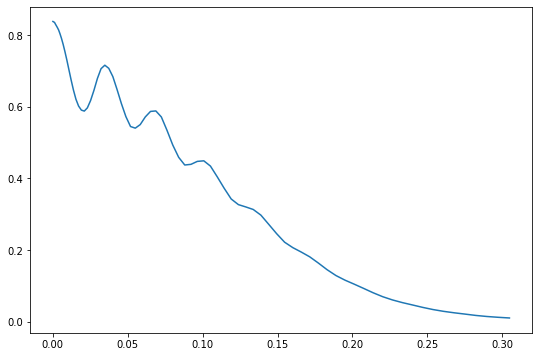

In [201]:
plt.plot(system.E_el_vec,trajectory[200,:system.n_kmax])
plt.show()

In [19]:

trajectory_rk4 = system.integrate(inits, n_steps=1001, dt=10.0, dt_out=10.0)

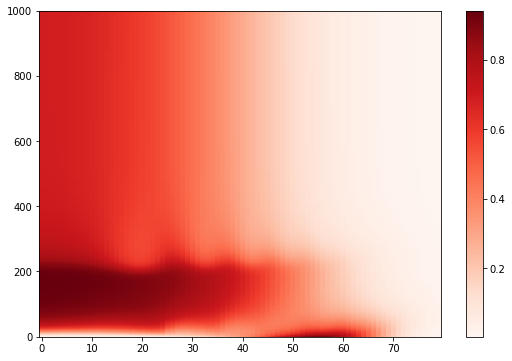

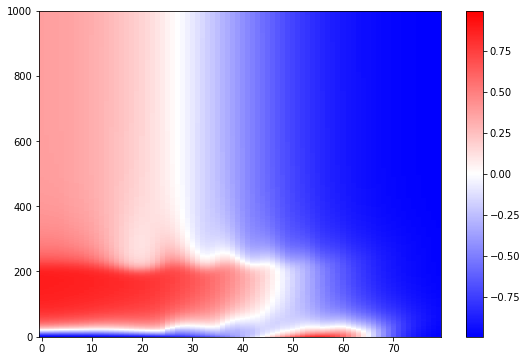

In [20]:
import matplotlib.colors as colors

plt.imshow(trajectory_rk4[:,:system.n_kmax], aspect='auto', interpolation='none', origin='lower',cmap='Reds')
plt.colorbar()
plt.show()


inversion_rk = 2*trajectory_rk4[:,:system.n_kmax] - 1.

plt.imshow(inversion_rk, aspect='auto', interpolation='none', origin='lower',
           cmap='bwr',
           norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

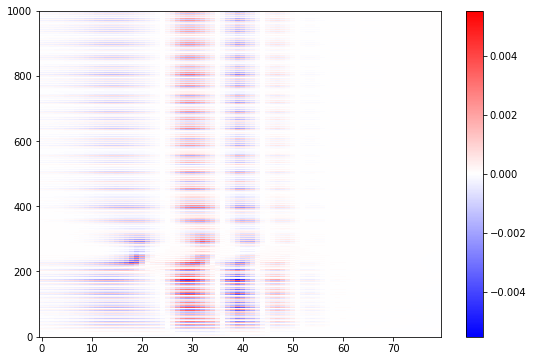

In [21]:
plt.imshow(trajectory[:,:system.n_kmax]-trajectory_rk4[:,:system.n_kmax], aspect='auto', interpolation='none', origin='lower',
           cmap='bwr',
           norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

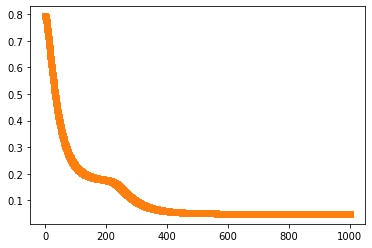

In [32]:
# %matplotlib notebook
%matplotlib inline

plt.plot(trajectory[:,60],marker='o')
plt.plot(trajectory_rk4[:,60],marker='s')
plt.show()